In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)
val_set = torchvision.datasets.MNIST(
    root=".", train=False, download=True, transform=transform
)

full_set = torch.utils.data.ConcatDataset([train_set, val_set])

batch_size = 16

train_loader = torch.utils.data.DataLoader(
    full_set, batch_size=batch_size, shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 134772976.64it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40690525.30it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79922934.83it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8877226.83it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
def plot_samples(real_samples):
    plt.figure()
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    
    plt.show()
    plt.close()

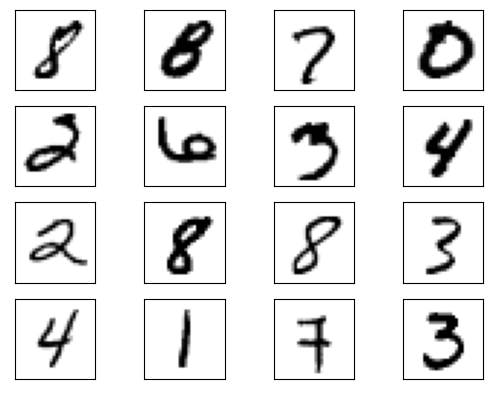

In [4]:
real_samples, mnist_labels = next(iter(train_loader))
plot_samples(real_samples)

In [5]:
class GANModule(nn.Module):
    def __init__(self, type, input_dim, hidden_sizes, output_dim, dropout=False, dropout_rate=0.3):
        super().__init__()
        
        self.type = type
        self.output_dim = output_dim

        layers = []
        previous_size = input_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout_rate))
            previous_size = hidden_size

        layers.append(nn.Linear(previous_size, output_dim))
        
        if type == 'discriminator':
            layers.append(nn.Sigmoid())
        elif type == 'generator':
            layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if self.type == 'discriminator':
            x = x.view(x.size(0), -1)
        output = self.model(x)

        if self.type == 'generator':
            output = output.view(x.size(0), 1, int((self.output_dim)**0.5), int((self.output_dim)**0.5))

        return output

In [6]:
def train(num_epochs, train_loader, batch_size, optimizer_discrimitor, optimizer_generator, loss_function, device):
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):

            # Data for training the discriminator

            real_samples = real_samples.to(device)

            real_samples_labels = torch.ones((batch_size, 1)).to(device)

            latent_space_samples = torch.randn((batch_size, 100)).to(device)

            generated_samples = generator(latent_space_samples)

            generated_samples_labels = torch.zeros((batch_size, 1)).to(device)

            all_samples = torch.cat((

                real_samples, generated_samples

            ))

            all_samples_labels = torch.cat(

                (real_samples_labels, generated_samples_labels)

            )


            # Training the discriminator

            discriminator.zero_grad()

            output_discriminator = discriminator(all_samples)

            loss_discriminator = loss_function(

                output_discriminator, all_samples_labels

            )

            loss_discriminator.backward()

            optimizer_discriminator.step()


            # Data for training the generator

            latent_space_samples = torch.randn((batch_size, 100)).to(device)


            # Training the generator

            generator.zero_grad()

            generated_samples = generator(latent_space_samples)

            output_discriminator_generated = discriminator(generated_samples)

            loss_generator = loss_function(

                output_discriminator_generated, real_samples_labels

            )

            loss_generator.backward()

            optimizer_generator.step()


            # Show loss

            if epoch % 20 == 0 and n == batch_size:

                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")

                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

                latent_space_samples = torch.randn(batch_size, 100).to(device)
                generated_samples = generator(latent_space_samples)
                generated_samples = generated_samples.cpu().detach()

                plot_samples(generated_samples)
                
    latent_space_samples = torch.randn(batch_size, 100).to(device)
    generated_samples = generator(latent_space_samples)
    generated_samples = generated_samples.cpu().detach()
    plot_samples(generated_samples)

network sized : 1 learning rate : 0.0001
Epoch: 0 Loss D.: 0.4512919783592224
Epoch: 0 Loss G.: 0.6011697053909302


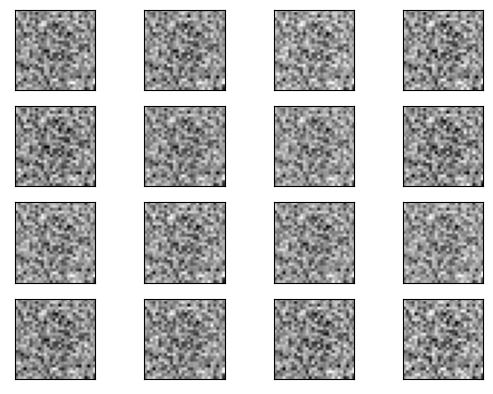

Epoch: 20 Loss D.: 1.587431256666605e-06
Epoch: 20 Loss G.: 13.931690216064453


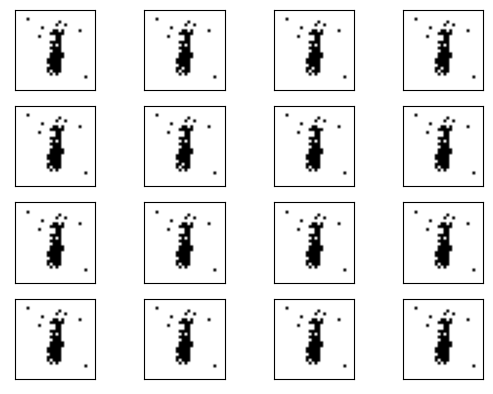

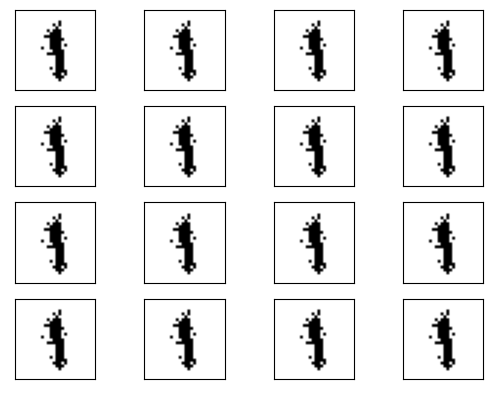

network sized : 1 learning rate : 0.0002
Epoch: 0 Loss D.: 0.6026835441589355
Epoch: 0 Loss G.: 0.44774329662323


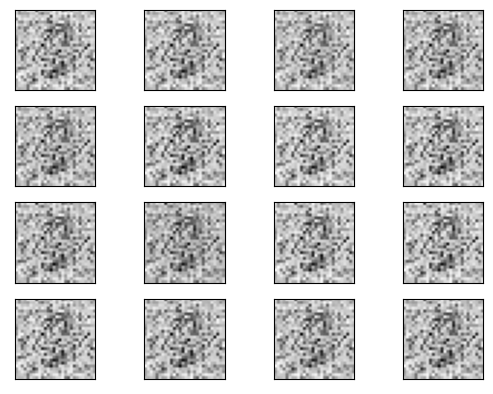

Epoch: 20 Loss D.: 0.644982635974884
Epoch: 20 Loss G.: 1.0763535499572754


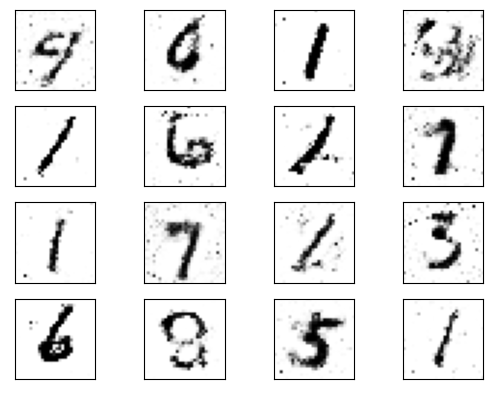

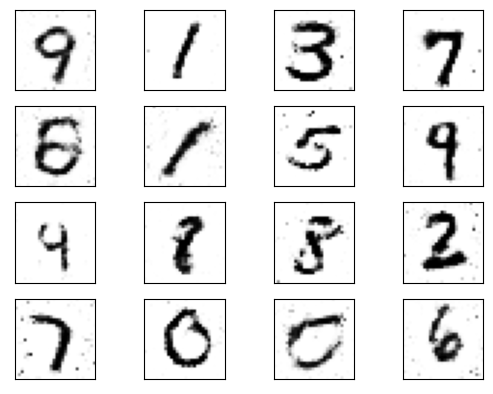

network sized : 2 learning rate : 0.0001
Epoch: 0 Loss D.: 0.6168774962425232
Epoch: 0 Loss G.: 0.44327661395072937


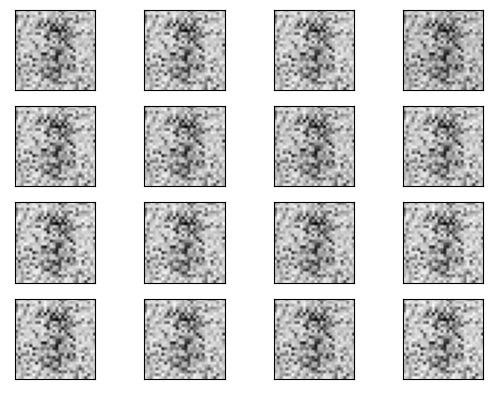

Epoch: 20 Loss D.: 0.5624626874923706
Epoch: 20 Loss G.: 1.175219178199768


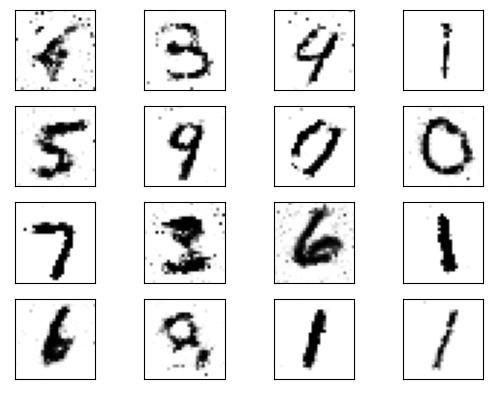

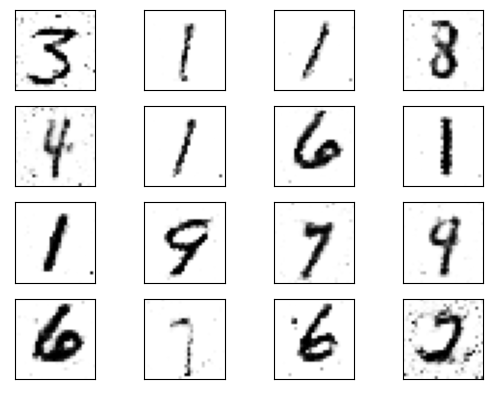

network sized : 2 learning rate : 0.0002
Epoch: 0 Loss D.: 0.5009148716926575
Epoch: 0 Loss G.: 1.134384036064148


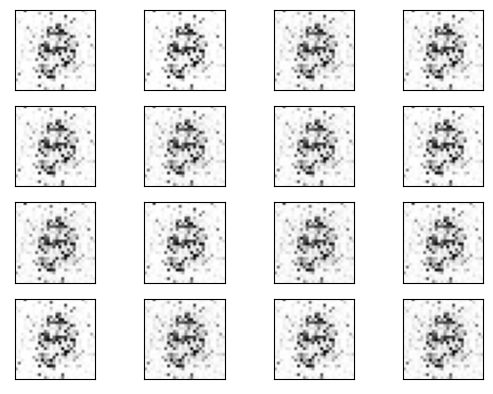

Epoch: 20 Loss D.: 0.48471468687057495
Epoch: 20 Loss G.: 1.1823575496673584


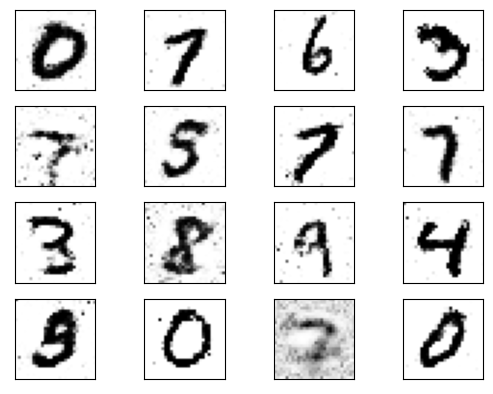

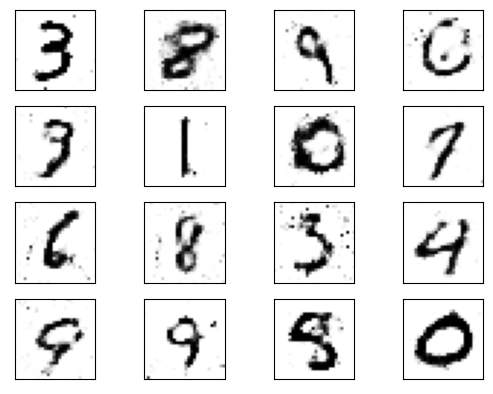

In [8]:
num_epochs = 40
loss_function = nn.BCELoss()

for w_n in [1, 2]:
    for w_lr in [0.0001, 0.0002]:
        print('network sized :', w_n, 'learning rate :', w_lr)
        discriminator = GANModule('discriminator', input_dim=784, hidden_sizes=[w_n * i for i in [1024, 512, 256]], output_dim=1, dropout=True, dropout_rate=0.2).to(device)
        generator = GANModule('generator', input_dim=100, hidden_sizes=[w_n * i for i in [256, 512, 1024]], output_dim=784).to(device)

        optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=w_lr)
        optimizer_generator = torch.optim.Adam(generator.parameters(), lr=w_lr)

        train(num_epochs, train_loader, batch_size, optimizer_discriminator, optimizer_generator, loss_function, device)